In [153]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.learn_utils import fit_dnn
from bgspy.learn import LearnedFunction


In [4]:
FIT_DIR = '../data/slim_sims/bmap_hg38/fits/'

res = load_learnedfuncs_in_dir(FIT_DIR)
res.keys()

2022-05-20 17:07:19.012691: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 17:07:21.721595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 485 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-05-20 17:07:21.722656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6120 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-05-20 17:07:21.723470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:

dict_keys([(0, 0, 0, 0, 4), (0, 0, 4, 2, 0), (0, 0, 0, 0, 2)])

In [14]:
y, X = res[(0, 0, 0, 0, 2)][0].func.y, res[(0, 0, 0, 0, 2)][0].func.X

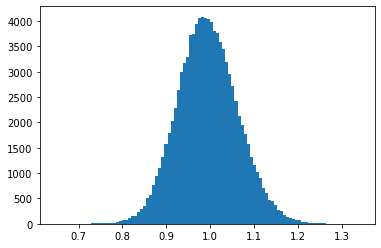

In [22]:
_ = plt.hist(y, 100)

In [145]:
class DownsampleTarget:
    def __init__(self, y, bins=100, rng=None):
        self.y = y.squeeze()
        self.bins = bins
        self.hist, self.bin_edges = np.histogram(y, bins=bins)
        self.seed = rng if isinstance(rng, int) else None
        self.rng = np.random.default_rng(self.seed) if rng is None else rng

    def downsample(self, level, truncate=True, replace=False):
        bin_item_idx = np.digitize(self.y, self.bin_edges)
        bin_items = defaultdict(list)
        
        for i, idx in enumerate(bin_item_idx.tolist()):
            bin_items[idx].append(i)
        sample = []
        for vals in bin_items.values():
            if len(vals) <= level:
                if not truncate:
                    sample.extend(vals)
            else:
                sample.extend(self.rng.choice(vals, size=level, replace=replace).tolist())
        return np.array(sample)

    def plot(self):
        return plt.bar(self.bin_edges[:-1], self.hist, width=np.diff(self.bin_edges)[0])
    

In [148]:
m = DownsampleTarget(y)
#plt.hist(m.downsample(level=100), bins=m.bin_edges)
idx = m.downsample(level=100)

In [157]:
domain = {'mu': (-10, -7, True),
         'sh': (-5, -1, True),
         'L': (1, 10000, False),
         'rbp': (-12, -7, True),
         'rf': (-10, -0.824, True)}

func = LearnedFunction(X[idx, :], y[idx, ], domain=domain)

In [159]:
fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2)

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>